In [1]:
import google.generativeai as genai
import utils

# Set up the model
generation_config = {
    "temperature": 1.0,
}

# Setting llms
genai.configure(api_key=utils.get_GEMINI_API_KEY())
model = genai.GenerativeModel('gemini-pro')  # for optimizerllm

prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

I have some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

text:
Solve this problem.
score:
34.61538461538461

text:
Let's think step by step.
score:
30.5

text:
Let’s solve this problem by splitting it into steps
score:
20

text:
Let’s think about this logically.
score:
15

text:
Take a deep breath and think through this.
score:
18

text:
Break this down.
score:
26.5

The following exemplars show how to apply your text: you replace <INS> in each input with your
text, then read the input and give an output. We say your output is wrong if your output is different
from the given output, and we say your output is correct if they are the same.

input:
Q: Julie, Letitia and Anton decided to have dinner together at a nearby restaurant.  Julie orders $10 worth of food, Letitia orders $20 worth of food, and Anton orders $30 worth of food.  How much should each pay in tips if they want to split a 20% tip for the whole meal evenly?
A: <INS>
output:
4

input:
Q: Don throws 3 darts.  One is a bullseye worth 50 points.  One completely missed the target, so received no points. The third was worth half the points of the bullseye.  What is the final score from these 3 throws?
A: <INS>
output:
75

input:
Q: Thomas made 4 stacks of wooden blocks. The first stack was 7 blocks tall. The second stack was 3 blocks taller than the first. The third stack was 6 blocks shorter than the second stack, and the fourth stack was 10 blocks taller than the third stack. If the fifth stack has twice as many blocks as the second stack, how many blocks did Thomas use in all?
A: <INS>
output:
55

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
"""

model.generate_content(prompt).text

"Let's approach this systematically."

In [10]:
import json
import statistics
# load opro.json
with open("opro_1.json") as f:
    opro = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {step: (statistics.mean(opro[step].values()), statistics.stdev(opro[step].values())) for step in opro}

Text(0.5, 1.0, 'Step to Accuracy')

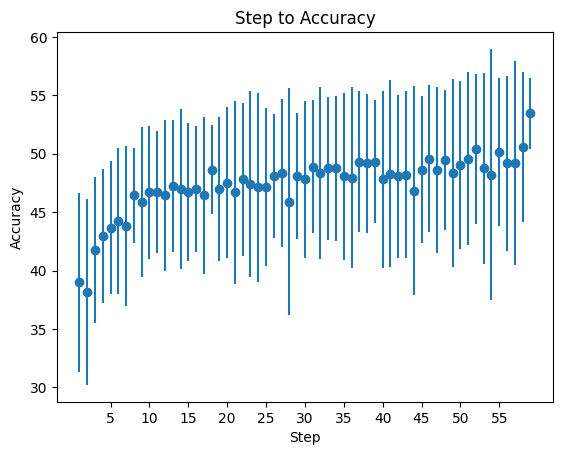

In [11]:
import matplotlib.pyplot as plt

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(step_to_accuracy.keys(), [accuracy[0] for accuracy in step_to_accuracy.values()], yerr=[accuracy[1] for accuracy in step_to_accuracy.values()], fmt='o')
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel('Step')
ax.set_ylabel('Accuracy')
ax.set_title('Step to Accuracy')

In [12]:
opro[str(len(opro))]

{"Let's solve this by breaking it down into subproblems": 57.692307692307686,
 "Let's dissect this formidable challenge into its constituent elements, systematically unraveling each facet to illuminate its complexities. By examining each component independently and synthesizing insights, we forge a path toward a comprehensive resolution, unlocking its hidden dimensions and illuminating the way to an optimal outcome. Through this collaborative and methodical approach, we endeavor to decipher its intricacies, ultimately forging a path toward a satisfactory conclusion.": 57.692307692307686,
 'Let us deconstruct this intricate enigma into its fundamental elements, systematically unraveling its intricacies and examining each component independently. Through a systematic exploration of its inherent complexities, we aim to illuminate the underlying mechanisms and forge a path toward resolution.': 57.692307692307686,
 "Let's dissect this multifaceted conundrum into its constituent components, 

### Testing optimized instruction on testing set

In [5]:
from datasets import load_dataset
from tqdm import tqdm

# load gsm8k dataset
SAMPLE_PERCENTAGE = 3.5/100
gsm8k_dataset = load_dataset("gsm8k", "main")
testing_sample = gsm8k_dataset["test"].shuffle(seed=42).select(range(200))
best_instruction = "Simplify this by systematically breaking it down and approaching it step by step using a rational approach"

def check_fast(actual, expected):
    """
    Faster and simpler version of the check function.
    """
    expected = expected.split("####")[-1].strip()
    return expected in actual

def test_instruction(lm, ins, testing_sample):
    score = 0
    for i in tqdm(range(len(testing_sample))):
        question = testing_sample["question"][i]
        answer = testing_sample["answer"][i]
        actual = lm(f"{question}\n{ins}")
        score += check_fast(actual, answer)
    return score / len(testing_sample) * 100

In [6]:
# Testing instruction with gpt (no ins vs ins)
from openai import OpenAI
import utils
client = OpenAI(api_key=utils.get_OPENAI_API_KEY_DJ())
def get_chat_completion(prompt, model="gpt-3.5-turbo-0125"):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    return response.choices[0].message.content

print("No instruction: ", test_instruction(get_chat_completion, "", testing_sample))
print("With instruction: ", test_instruction(get_chat_completion, best_instruction, testing_sample))

100%|██████████| 200/200 [13:33<00:00,  4.07s/it]


No instruction:  85.5


100%|██████████| 200/200 [13:42<00:00,  4.11s/it]

With instruction:  85.5


In [9]:
# Testing instruction with ollama (no ins vs ins)
from langchain_community.llms import Ollama
from requests import ReadTimeout

llm = Ollama(model="gemma:2b", temperature=0, num_gpu = 40, timeout=30)  # for scorerllm
def lm_ollama(prompt):
    temp = llm.timeout
    while True:
        try:
            res = llm.invoke(prompt)
            break
        except ReadTimeout:
            if llm.timeout > 120:
                print(f"Inference lasted for {llm.timeout} seconds. Stopping now.")
                break
            llm.timeout *= 2
            print(f"### ReadTimeout. Trying again with Timeout: {llm.timeout} seconds ###")
        except Exception as e:
            print(f"### {e} ###")
            break
    llm.timeout = temp
    return res

print("No instruction: ", test_instruction(lm_ollama, "", testing_sample))
print("With instruction: ", test_instruction(lm_ollama, best_instruction, testing_sample))

100%|██████████| 200/200 [04:21<00:00,  1.31s/it]


No instruction:  18.5


100%|██████████| 200/200 [08:12<00:00,  2.46s/it]

With instruction:  24.5


In [13]:
best_instruction = "Let's solve this by breaking it down into subproblems"
print("gpt - No instruction: ", test_instruction(get_chat_completion, "", testing_sample))
print("gpt - With instruction: ", test_instruction(get_chat_completion, best_instruction, testing_sample))
print("gemma - No instruction: ", test_instruction(lm_ollama, "", testing_sample))
print("gemma - With instruction: ", test_instruction(lm_ollama, best_instruction, testing_sample))

100%|██████████| 200/200 [08:48<00:00,  2.64s/it]


gpt - No instruction:  85.0


100%|██████████| 200/200 [13:04<00:00,  3.92s/it]


gpt - With instruction:  84.0


100%|██████████| 200/200 [04:06<00:00,  1.23s/it]


gemma - No instruction:  18.0


100%|██████████| 200/200 [07:37<00:00,  2.29s/it]

gemma - With instruction:  27.500000000000004
